In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core import KoopDNN,KoopmanNet,KoopmanNetCtrl
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift
from dynamics.duffing import dynamics_duff
from dynamics.Vanpol import dynamics_vanpol
from dynamics.lorentz import dynamics_lorenz

from core.adapt_net import AdaptNet
import scipy.io

In [2]:
# Base Parameters
dt = 0.005 #time step
num_snaps = 2000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [3]:
# # Oscillator parameters for duffing
system = "Duffing_control"
percent_change = 10
dyn_pars = {}
if system=="Duffing_control":
    num_states = 2
    num_inputs = 1

    dyn_pars['a'] = -1
    dyn_pars['b'] = 1
    dyn_pars['c'] = 0.2
    dyn_pars['d'] = 0.3
    
    dyn_pars['del_a'] = -1.5
    dyn_pars['del_b'] = 1.5
    dyn_pars['del_c'] = 0.3
    dyn_pars['del_d'] = 0.2
    dyn_pars['del_e'] = 0.0
    
    dyn_pars['delay'] = False
    dyn_pars['delay_time'] = 5
    dyn_pars['cont_unc_type'] = 'sinusoidal'

elif system == "Vander_control":
    # Oscillator parameters for Van Der pol Oscillator
    num_states = 2
    num_inputs = 1
    mu = 2

    dyn_pars['a'] = 1
    dyn_pars['b'] = mu
    dyn_pars['c'] = 0.5
    dyn_pars['d'] = mu

    dyn_pars['del_a'] = dyn_pars['a']*percent_change/100
    dyn_pars['del_b'] = dyn_pars['b']*percent_change/100
    dyn_pars['del_c'] = dyn_pars['c']*percent_change/100
    dyn_pars['del_d'] = dyn_pars['d']*percent_change/100
    dyn_pars['delay'] = False
    dyn_pars['delay_time'] = 5
    dyn_pars['cont_unc_type'] = 'sinusoidal'

In [4]:
if system =="Duffing_control":
    X_changed, X_unchanged, U = dynamics_duff(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)
elif system=="Vander_control":
    X_changed, X_unchanged, U = dynamics_vanpol(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)
elif system=="lorenz":
    X_changed, X_unchanged = dynamics_lorenz(dt, num_traj, num_snaps, num_states, dyn_pars)
    U = np.zeros((num_traj,num_snaps,num_inputs))

print(X_changed.shape, U.shape)

(125, 2001, 2) (125, 2000, 1)


In [5]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [6]:
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

l2_diff =  0.41234178537228383


In [7]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  0.3927934251994658


In [8]:
file_img = 'saved_models/'+system+"/"+str(percent_change)+'/'

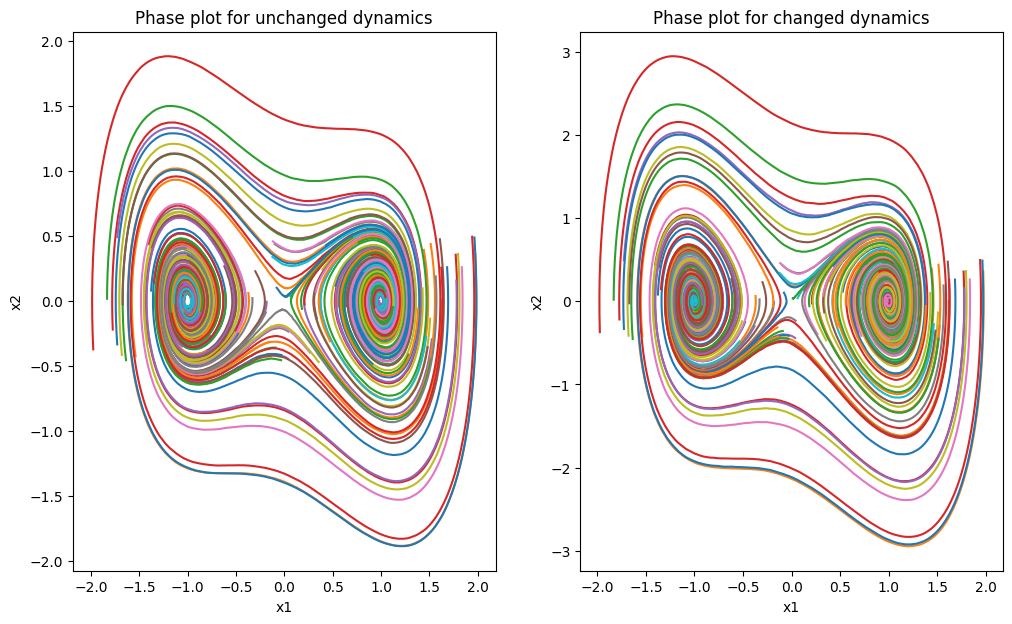

In [9]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])
plt.savefig(file_img+'phase_plot_duffing.pdf')

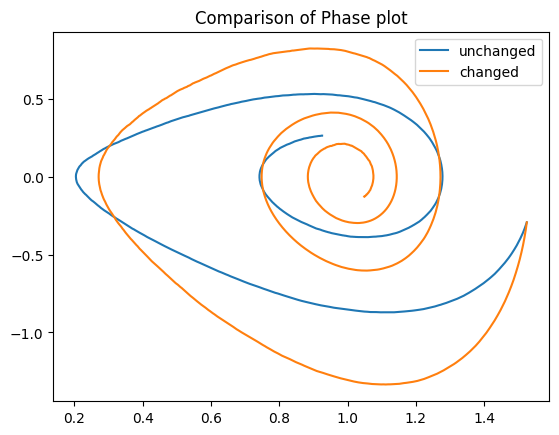

In [10]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.savefig(file_img+'phase_plot_duffing_single_traj.pdf')
plt.show()


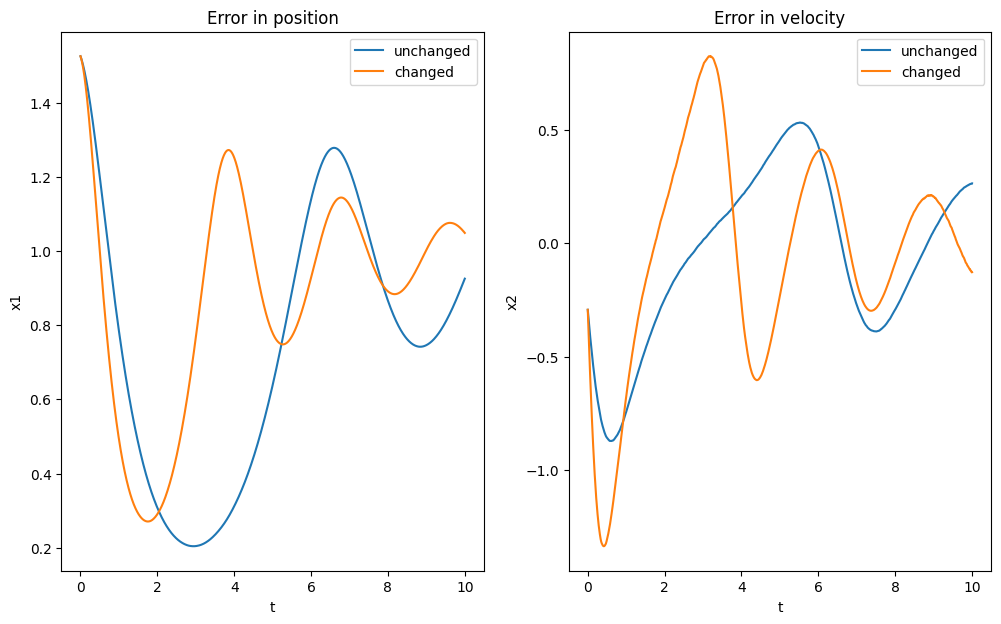

In [11]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_unchanged[4,:,0], label = 'unchanged')
axs[0].plot(T, X_changed[4,:,0], label = 'changed')
axs[0].legend()

axs[1].plot(T, X_unchanged[4,:,1], label = 'unchanged')
axs[1].plot(T, X_changed[4,:,1], label = 'changed')
axs[1].legend()

plt.savefig(file_img+'vel_pos_err_duffing_single_traj.pdf')

In [12]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

***Koopman bilinear Models***

In [13]:
# auto encoder parameters

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 5
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 2e-4 # 5e-4
net_params['epochs'] = 200
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [14]:
train = False
standardize = False

file_koop = 'saved_models/'+system+'/koop_duffing_control_dim5.pth'
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean = True))

if train == True:

    if standardize:
        net = KoopmanNetCtrl(net_params, standardizer_u=standardizer_u_kdnn)
    else:
        net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file_koop)
else:
    model_koop_dnn = torch.load(file_koop)

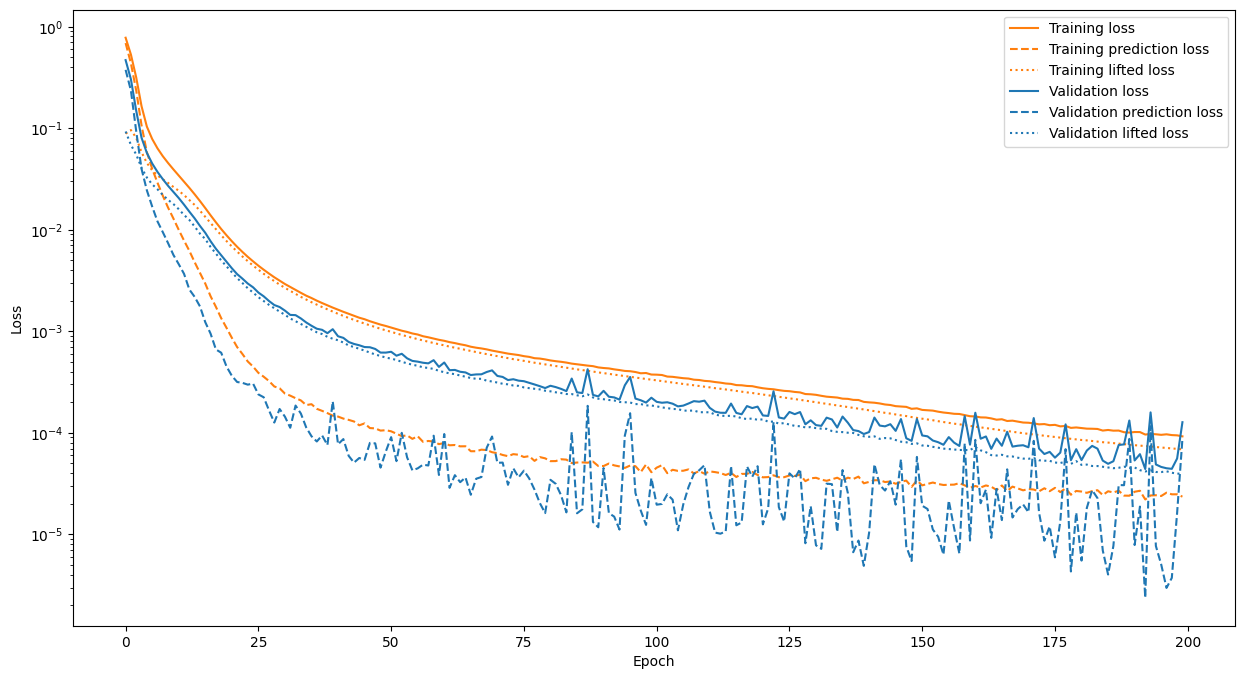

In [15]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Learned Model Parameters

## Bilinear Model Parameters

In [16]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(8, 8) (8, 8) (2, 8)


In [17]:
# # SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io
#
# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat("dyn_mat.mat", dyn_matrices)
# #save encoder parameters
# scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})
#
# scipy.io.savemat("hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})
#
# scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

## Lifting function

# Testing

## Parameters

In [18]:
# test data parameters
num_snaps_test = 5000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const

## Testing Data

In [19]:
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const

In [20]:
if system =="Duffing_control":
    x_changed_test, x_unchanged_test, u_test = dynamics_duff(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
elif system=="Vander_control":
    x_changed_test, x_unchanged_test, u_test = dynamics_vanpol(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
elif system=="lorenz":
    x_changed_test, x_unchanged_test = dynamics_lorenz(dt, num_traj_test, num_snaps_test,num_states, dyn_pars)
    u_test = np.zeros((num_traj_test, num_snaps_test,num_inputs))
print(model_koop_dnn.test_loss(x_unchanged_test,u_test = u_test))

tensor(0.0002)


In [21]:
# Use the preprocessing if available
X_unchanged,_ = model_koop_dnn.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn.net.process(x_changed_test,data_u = u_test)

In [22]:
num_snaps_test = x_changed_test.shape[1]-1
num_traj_test = x_changed_test.shape[0]

In [23]:
# initialize the matricies
z_test = np.zeros((num_traj_test, num_snaps_test+1, n_obs))
x_est = np.zeros((num_traj_test, num_snaps_test+1, num_states))
x_est[:,0,:] = x_changed_test[:,0,:]

# Lifting of states

In [24]:
for i in range(num_traj_test):

    z_test[i, 0, :] = lift(x_changed_test[i, 0, :].reshape(num_states), model_koop_dnn, net_params)
    for j in range(num_snaps_test):
        #bilinear
        z_test[i, j+1,:] = np.matmul(z_test[i, j,:],A.T)+np.matmul(np.kron(u_test[i,j,:],z_test[i, j,:]),B.T)
        x_est[i, j+1,:] = np.matmul(z_test[i,j+1,:],C.T)

In [25]:
model_error = np.absolute(x_changed_test-x_est)

In [26]:
model_error_std = np.zeros((num_traj_test,num_snaps_test,num_states))

# Time Evolution

In [27]:
for i in range(num_traj_test):
    for j in range(num_snaps_test):
        for k in range(num_states):
            model_error_std[i,j,k] = model_error[i,j,k]/np.absolute(x_changed_test[i,j,k]) if x_changed_test[i,j,k] else 0

In [28]:
mean_error = model_error_std.mean()
mean_error


18.580550919473644

In [29]:
np.percentile(model_error_std, 25)


1.4760836927982541

In [30]:
np.percentile(model_error_std, 50)


2.1288564929867047

In [31]:
np.percentile(model_error_std, 75)

4.780953612142827

In [32]:
x_changed = x_changed_test.reshape((num_snaps_test+1,num_states))
x_unchanged = x_unchanged_test.reshape((num_snaps_test+1,num_states))
x_unchanged_est = x_est.reshape((num_snaps_test+1,num_states))

# Plotting

## Lifting performance

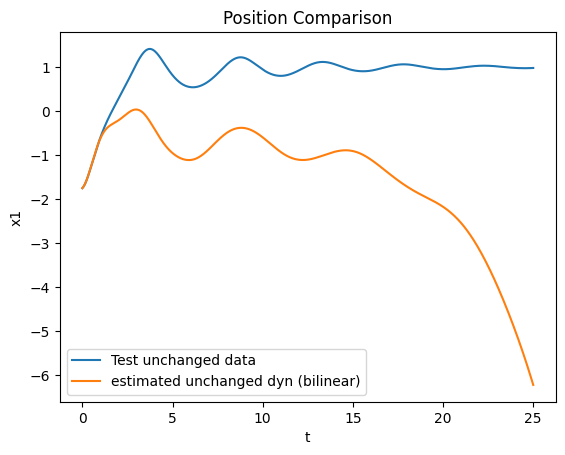

In [33]:
plt.figure()
plt.plot(T_test, x_unchanged[:,0],label ='Test unchanged data')
plt.plot(T_test, x_unchanged_est[:,0],label = 'estimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

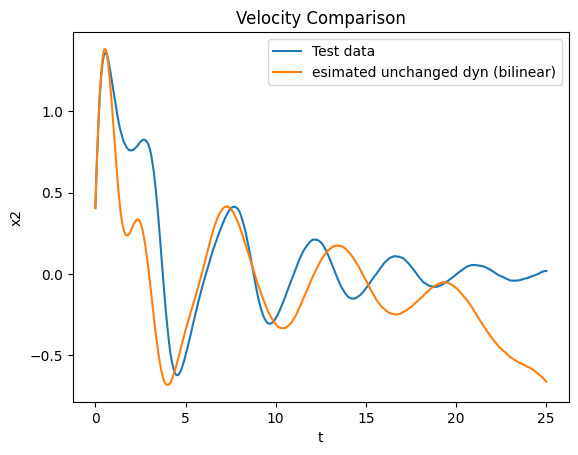

In [34]:
plt.figure()
plt.plot(T_test,x_unchanged[:,1],label ='Test data')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

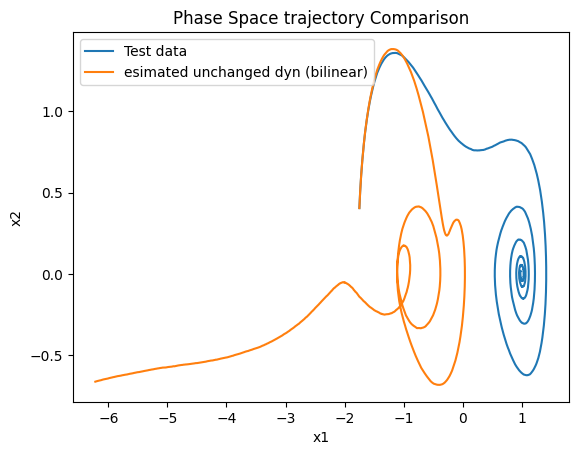

In [35]:
plt.figure()
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

### Error Evolution

In [36]:
error_model = np.linalg.norm((x_unchanged_est-x_unchanged),axis=1)
error_dynamics_no_adapt = np.linalg.norm((x_changed-x_unchanged),axis=1)

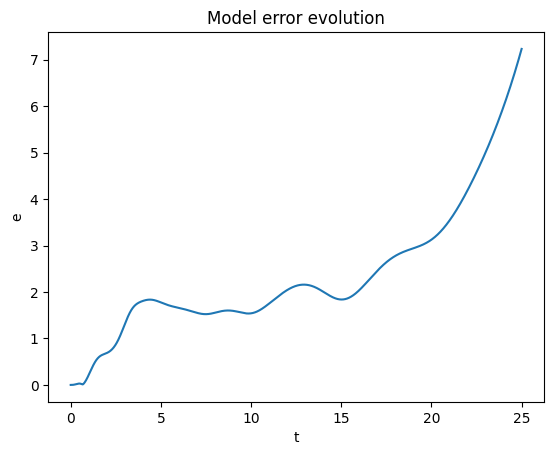

In [37]:
plt.figure()
plt.plot(T_test,error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

## Deviation from Actual Dynamics

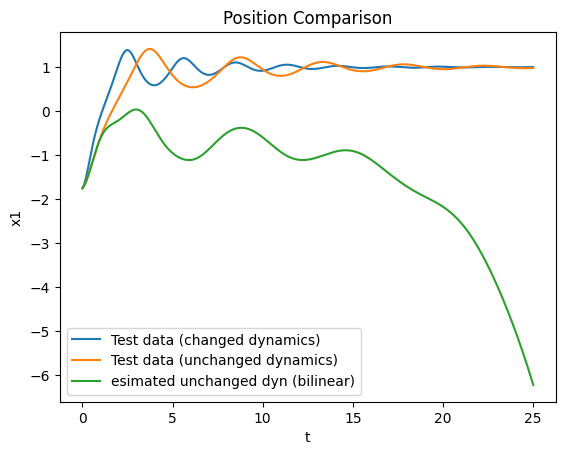

In [38]:
plt.figure()
plt.plot(T_test,x_changed[:,0],label ='Test data (changed dynamics)')
plt.plot(T_test,x_unchanged[:,0],label ='Test data (unchanged dynamics)')
plt.plot(T_test,x_unchanged_est[:,0],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

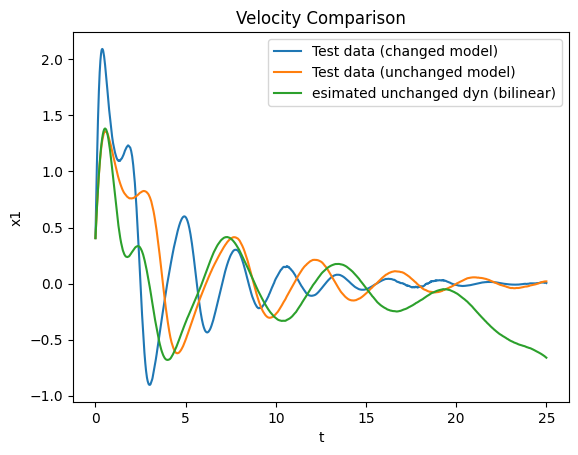

In [39]:
plt.figure()
plt.plot(T_test,x_changed[:,1],label ='Test data (changed model)')
plt.plot(T_test,x_unchanged[:,1],label ='Test data (unchanged model)')
plt.plot(T_test,x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

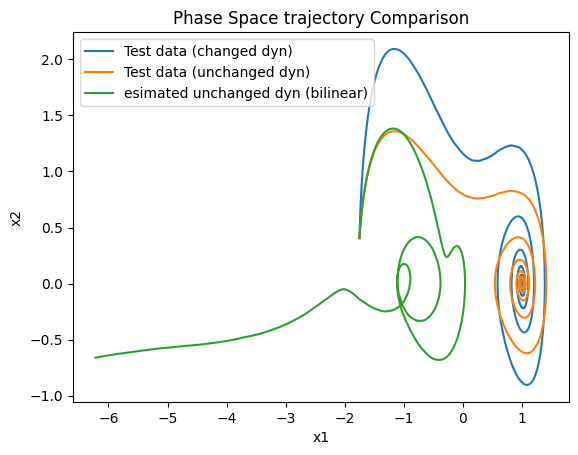

In [40]:
plt.figure()
plt.plot(x_changed[:,0],x_changed[:,1],label ='Test data (changed dyn)')
plt.plot(x_unchanged[:,0],x_unchanged[:,1],label ='Test data (unchanged dyn)')
plt.plot(x_unchanged_est[:,0],x_unchanged_est[:,1],label = 'esimated unchanged dyn (bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

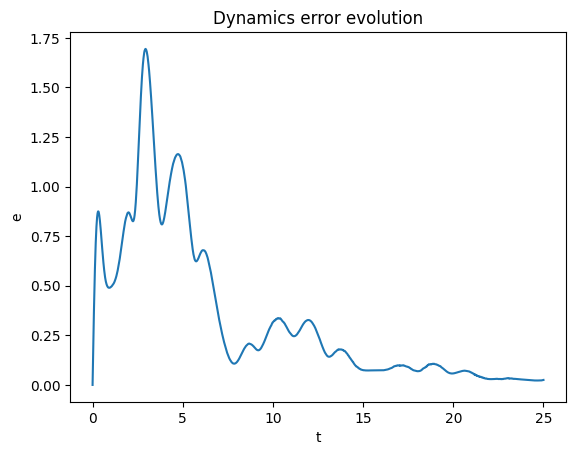

In [41]:
plt.figure()
plt.plot(T_test,error_dynamics_no_adapt)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')
plt.show()

# Adaptation

## Data Preprocessing

# Adaptive Time evolution

In [42]:
adap_window = 5 #hyperparameter

adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 1e-5 # 5e-4
adapt_net_params['epochs'] = 10
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 5e-1
adapt_net_params['l1_reg'] = 5e-1
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

In [43]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from dynamics.learned_models_control.bilinear_dynamics import bilinear_Dynamics
import scipy

In [44]:
bilinear_model_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
bilinear_model_no_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)

In [45]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 6
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [46]:
#Closed loop performance evaluation parameters:
traj_length = 2000
max_iter = 2000
N = 20 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = 200*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
# Q_mpc = np.array([[400,0],[0,200]])
QN_mpc = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc = 0.018*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# Design trajectory:
xt = np.empty((traj_length+1, num_states))
xt[0,:] = 1*np.array([0, 0])                   # Initial value, closed loop trajectory

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
xmax = 5*np.array([1, 1])                          # State constraints, trajectory generation
xmin = -xmax
umax = 100*np.array([1])
umin = -umax

# Define initial solution for SQP algorithm:
x_init = np.linspace(xt[0,:], xt[0,:], N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [47]:
x_ref = np.empty((num_states,traj_length+1))
for i in range(traj_length+1):
    x_ref[:,i] = np.array([0.5*np.sin(2*i*dt), np.cos(2*i*dt)])

In [48]:
n_lift = A.shape[0]
z_init = np.empty((N+1, n_lift))
z0 = lift(xt[0,:], model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)


In [49]:
# initialize state matricies
u = np.zeros((traj_length, num_inputs))
z_new_dyn = np.empty((n_obs, traj_length+1)).T   #lifted state
zt_old_dyn = np.empty((n_obs, traj_length+1)).T #actual lifted state
del_z_prime = np.empty((n_obs, traj_length)).T
zu_old_dyn = np.empty((n_obs*num_inputs, traj_length)).T
x_new_dyn = np.empty((num_states, traj_length+1)).T #estimated values
del_A_norm = np.zeros((traj_length,1))
del_B_norm = np.zeros((traj_length,1))

# initialize
z_new_dyn[0,:] = zt_old_dyn[0,:] = z0
x_new_dyn[0,:]  = xt[0,:]


In [50]:
#controller that works on adapting model
controller_nmpc_adapt = NonlinearMPCController(bilinear_model_adapt, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc_adapt.construct_controller(z_init, u_init, x_ref[:,0])

In [51]:
from dynamics.learned_models_control.duff_adapt import Duff_adapt
from dynamics.learned_models_control.vander_adapt import Vander_adapt

In [52]:

for i in range(traj_length):
  # incorrect dynamics
    z_new_dyn[i,:] = lift(x_new_dyn[i,:], model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_new_dyn[i,:] - zt_old_dyn[i,:]
    zu_old_dyn[i,:] = np.kron(u[i,:], zt_old_dyn[i,:])

    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_old = zt_old_dyn[i-(adap_window+1):i-1].T
        ZU_old = zu_old_dyn[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet(adapt_net_params)
        adapt_network.model_pipeline(Z_old, ZU_old, del_Z_prime, print_epoch = True)
        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)

    bilinear_model_adapt.A = scipy.sparse.csc_matrix(bilinear_model_adapt.A.toarray() + del_A)
    bilinear_model_adapt.B = scipy.sparse.csc_matrix(bilinear_model_adapt.B.toarray() + del_B)

    controller_nmpc_adapt.solve_to_convergence(x_ref[:,i+1], zt_old_dyn[i,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter, eps = 1e-5)
    controller_nmpc_adapt.update_initial_guess_()
    u[i,:] = controller_nmpc_adapt.cur_u[0,:]

    # adapted model
    zt_old_dyn[i+1,:] = controller_nmpc_adapt.z_N0
    xt[i+1,:] = np.matmul(zt_old_dyn[i+1,:],C.T)

    if system == "Duffing_control":
        _, x_new_dyn[i+1,:] = Duff_adapt(dt, xt[i,:], u[i,:], num_states, dyn_pars)
    elif system=="Vander_control":
        _, x_new_dyn[i+1,:] = Vander_adapt(dt, xt[i,:], u[i,:], num_states, dyn_pars)

In [53]:
i

1999

In [54]:
xt

array([[0.00000000e+00, 0.00000000e+00],
       [2.25137262e-04, 9.85962608e-02],
       [9.14576518e-04, 1.87463388e-01],
       ...,
       [4.01873886e-01, 5.02884230e-01],
       [4.04346257e-01, 4.94407629e-01],
       [4.06761174e-01, 4.85882874e-01]])

In [55]:
#controller that works on old model (unadapted)
N_noadapt = N #length of horizon
Q_mpc_noadapt = 100*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc_noadapt = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc_noadapt = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc_noadapt = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
xmax_noadapt = 3*np.array([1, 1])                          # State constraints, trajectory generation
xmin_noadapt = -xmax
umax_noadapt = 20*np.array([1])
umin_noadapt = -umax

In [56]:
controller_nmpc_noadapt = NonlinearMPCController(bilinear_model_no_adapt, N_noadapt, dt, umin_noadapt, umax_noadapt, xmin_noadapt, xmax_noadapt, Q_mpc_noadapt, R_mpc_noadapt, QN_mpc_noadapt, solver_settings)
controller_nmpc_noadapt.construct_controller(z_init, u_init, x_ref[:,0])
# controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)


In [57]:
xt_no_adapt = np.empty((num_states,traj_length+1)).T
x_new_noadapt = np.empty((num_states,traj_length+1)).T
xt_no_adapt[0,:] = x_new_noadapt[0,:] = xt[0,:]
u_no_adapt = np.empty((num_inputs, traj_length)).T
z_no_adapt = np.empty((n_obs, traj_length+1)).T

for i in range(traj_length):
    # incorrect dynamics
    z_no_adapt[i,:] = lift(x_new_noadapt[i,:], model_koop_dnn, net_params)

    controller_nmpc_noadapt.solve_to_convergence(x_ref[:,i+1], z_no_adapt[i,:], controller_nmpc_noadapt.z_init, controller_nmpc_noadapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_noadapt.update_initial_guess_()
    u_no_adapt[i,:] = controller_nmpc_noadapt.cur_u[0,:]

    # adapted model
    xt_no_adapt[i+1,:] = np.matmul(controller_nmpc_noadapt.z_N0, C.T)

    _, x_new_noadapt[i+1,:] = Duff_adapt(dt, xt_no_adapt[i,:], u_no_adapt[i,:], num_states, dyn_pars)

# Performance Plotting

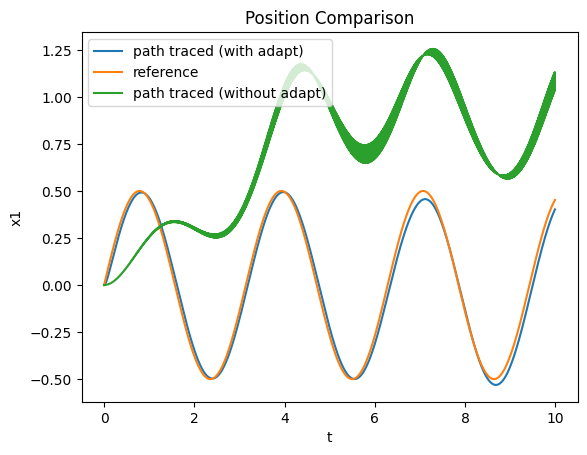

In [58]:
plt.figure()
plt.plot(t_eval[:i], xt[:i,0],label ='path traced (with adapt)')
plt.plot(t_eval[:i], x_ref[0,:i], label="reference")
plt.plot(t_eval[:i], xt_no_adapt[:i,0], label='path traced (without adapt)')
# plt.plot(T_test,x_adap_est[:,0],label = 'esimated (adapt)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
# plt.savefig(file_img+'.pdf')
plt.show()

In [59]:
i

1999

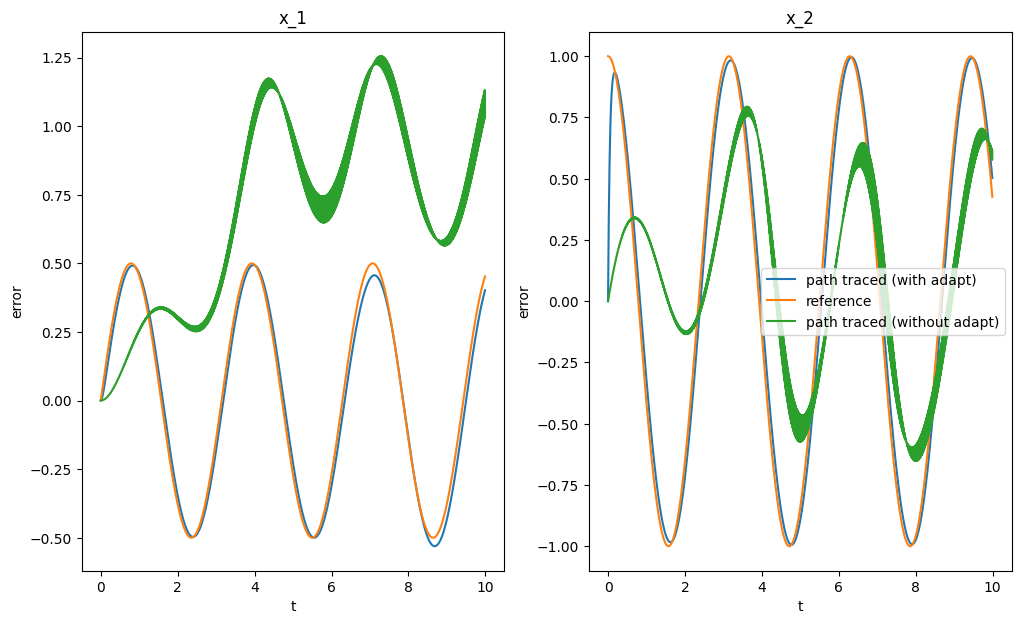

In [60]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("x_1")
axs[1].set_title("x_2")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')


axs[0].plot(t_eval[:i], xt[:i,0],label ='path traced (with adapt)')
axs[0].plot(t_eval[:i], x_ref[0,:i], label="reference")
axs[0].plot(t_eval[:i], xt_no_adapt[:i,0], label='path traced (without adapt)')

axs[1].plot(t_eval[:i], xt[:i,1],label ='path traced (with adapt)')
axs[1].plot(t_eval[:i], x_ref[1,:i], label="reference")
axs[1].plot(t_eval[:i], xt_no_adapt[:i,1], label='path traced (without adapt)')
plt.legend()
plt.savefig(file_img+'states_duffing_control.pdf')

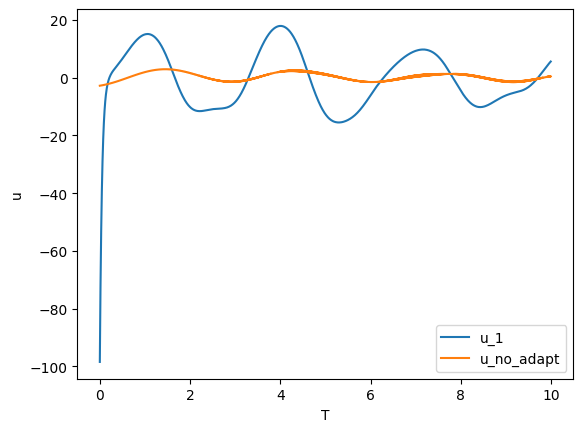

In [61]:
plt.figure()
plt.plot(t_eval[0:i], u[:i],label ='u_1')
plt.plot(t_eval[0:i], u_no_adapt[:i],label ='u_no_adapt')
plt.xlabel('T')
plt.ylabel("u")
plt.legend()
plt.savefig('control.pdf')
plt.savefig('controls.pdf')
plt.show()

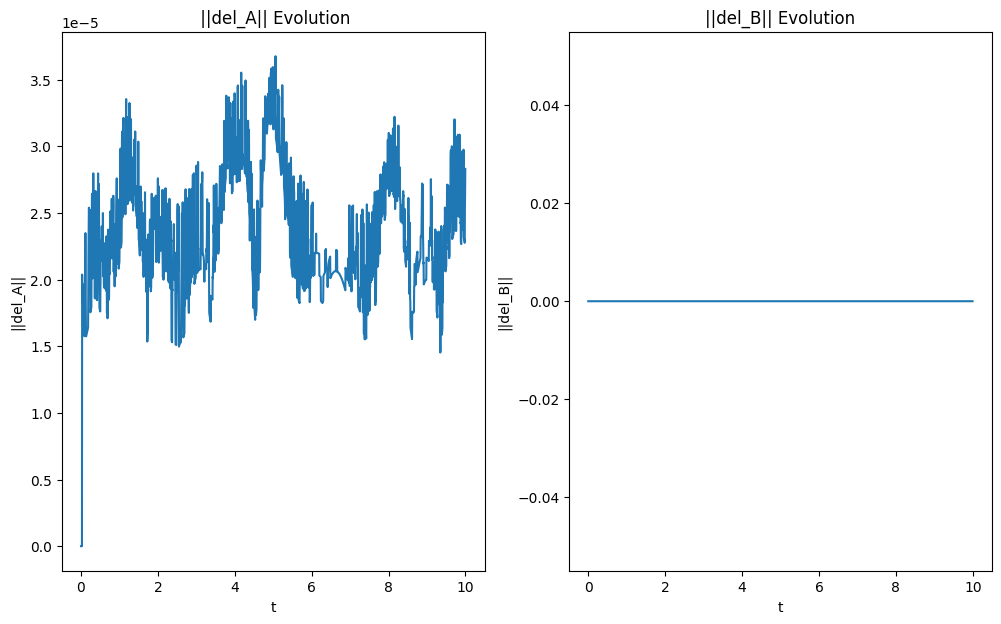

In [62]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(t_eval[:-1],del_A_norm)

axs[1].plot(t_eval[:-1],del_B_norm)
plt.savefig('norms.pdf')
plt.show()

# Error Comparisons

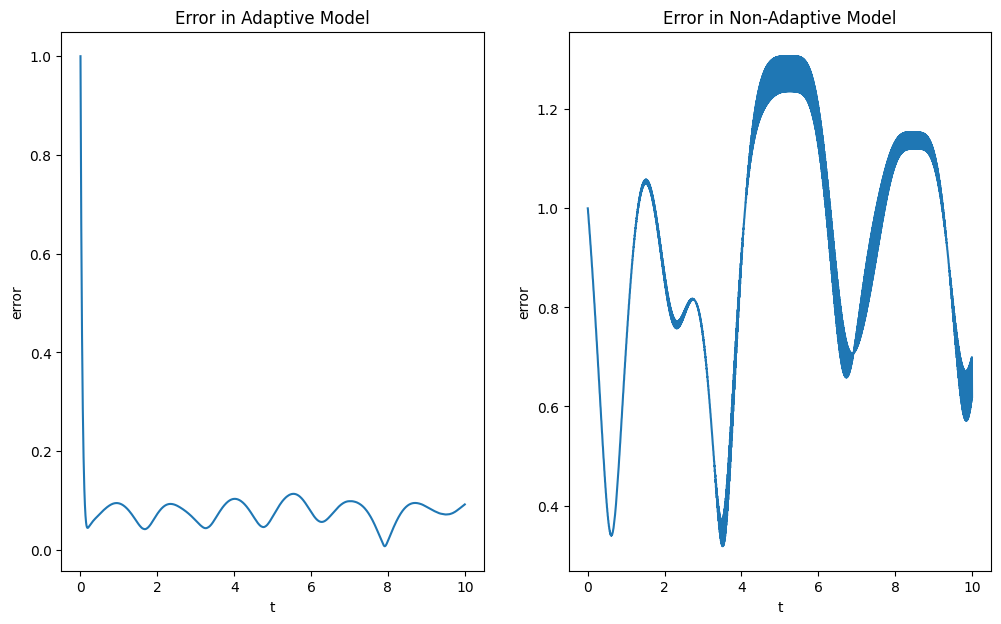

In [63]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in Adaptive Model")
axs[1].set_title("Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')
error_dynamics_adap =  np.linalg.norm((x_ref.T - xt), axis=1)
error_dynamics_no_adapt =  np.linalg.norm((x_ref.T - xt_no_adapt), axis=1)

axs[0].plot(t_eval,error_dynamics_adap)

axs[1].plot(t_eval,error_dynamics_no_adapt)

plt.savefig(file_img+'error_duffing_control.pdf')

In [64]:
error_dynamics_adap

array([1.        , 0.90136639, 0.81238742, ..., 0.0917302 , 0.09202573,
       0.09232657])

In [65]:
error_dynamics_adap

array([1.        , 0.90136639, 0.81238742, ..., 0.0917302 , 0.09202573,
       0.09232657])